# **EA044A – PLANEJAMENTO E ANÁLISE DE SISTEMAS DE PRODUÇÃO**
## Projeto T4 - Planejamento de Produção em Sistemas de Manufatura

###Bryan Wolff  RA: 214095
###Raphael Cury Spiller  RA: 186300


#**Item A**
**Formular o modelo de otimização discreto para planejar a produção.**

Seguindo a notação do OR-TOOLS, podemos descrever o problema da seguinte forma:

Onde cada task é representada por (M,t) onde M é a máquina pela qual deve passar e t o tempo de processamento naquela máquina. As tasks estão organizadas da seguinte forma:

> $job_0 = [(0,10),(1,10),(2,10)]$

> $job_1 = [(0,8),(1,5),(2,5)]$

> $job_2 = [(0,9),(1,9),(2,5)]$

> $job_3 = [(0,6),(1,5),(2,9)]$



Para definir as restrições, vamos utilizar a notação $t_{i,j}$ é o tempo inicial que o job i começa o processamento j.

Como na documentação do OR-TOOLS, definimos dois tipos de restrição, a de precedência e as para evitar sobreposição. Inicialmente definidmos as de precedência:

O tempo de início do segundo processamento do job 0 deve ser superior ao tempo gasto pela primeiro desse job. Extendendo essa definição para todos os jobs dados:

>$t_{0,2} \geq t_{0,1} + 10  $

>$t_{0,3} \geq t_{0,2} + 10  $

>$t_{1,2} \geq t_{1,1} + 8  $

>$t_{1,3} \geq t_{1,2} + 5  $

>$t_{2,2} \geq t_{2,1} + 9  $

>$t_{2,3} \geq t_{2,2} + 9  $

>$t_{3,2} \geq t_{3,1} + 6  $

>$t_{3,3} \geq t_{3,2} + 5  $


Essas restrições não impedem que uma maquina tenham dois processamentos de jobs diferentes ocorrendo ao mesmo tempo(o que na prática é inviável), por isso é necessário implementar um segundo nível de restrições. Ou seja, sabendo que há 3 processamentos por job e que cada um ocorre em uma máquina diferente, o tempo que um processamento j de um job i começa em uma máquina deve ser maior que o tempo em que o mesmo processamento ocorre no job anterior. 

$M_0$
>$t_{0,1} + 10 <= t_{1,1}$

>$t_{1,1} + 8 <= t_{2,1}$

>$t_{2,1} + 9 <= t_{3,1}$

$M_1$
>$t_{0,2} + 10 <= t_{1,2}$

>$t_{1,2} + 5 <= t_{2,2}$

>$t_{2,2} + 9 <= t_{3,2}$

$M_2$
>$t_{0,3} + 10 <= t_{1,3}$

>$t_{1,3} + 5 <= t_{2,3}$

>$t_{2,3} + 5 <= t_{3,3}$

Com isto temos todas as restrições definidas para o problema. Agora temos que montar o solver com o OR-TOOLS.


#**Item B**

**Implementando o modelo usando o OR-Tools para Mixed-Integer Programming (MIP) em Python**



####**Dependências**

In [ ]:
!pip install --user --upgrade pip setuptools wheel six ortools

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [ ]:
import collections
from ortools.sat.python import cp_model

####**Implementando o modelo**

In [ ]:
def MinimalJobshopSat():
    model = cp_model.CpModel() #define o modelo

    jobsData = [ #task = (máquina, tempoGasto)
                 [(1,10),(2,10),(0,10)],  #Job0
                 [(1,5),(0,8),(2,5)],     #Job1
                 [(2,5),(1,9),(0,9)],      #Job2
                 [(0,6),(2,9),(1,5)],     #Job4
    ]

    # Máquinas
    machineCount = 1 + max(task[0] for job in jobsData for task in job)
    allMachines = range(machineCount)

    # Soma de todas os tempos de forma dinâmica
    horizon = sum(task[1] for job in jobsData for task in job)

    # Nomeia a tupla que irá guardar as informações da nova variável
    task_type = collections.namedtuple('task_type', 'start end interval')
    
    # Tupla da solução
    assigned_task_type = collections.namedtuple('assigned_task_type',
                                                'start job index duration')

    allTasks = {}
    machineToIntervals = collections.defaultdict(list)
    for job_id, job in enumerate(jobsData):
        for task_id, task in enumerate(job):
            machine = task[0]
            duration = task[1]
            suffix = '_%i_%i' % (job_id, task_id)
            start_var = model.NewIntVar(0, horizon, 'start' + suffix)
            end_var = model.NewIntVar(0, horizon, 'end' + suffix)
            interval_var = model.NewIntervalVar(start_var, duration, end_var,
                                                'interval' + suffix)
            allTasks[job_id, task_id] = task_type(
                start=start_var, end=end_var, interval=interval_var)
            machineToIntervals[machine].append(interval_var)

    # Restrição para evitar Overlap (sobreposição das máquinas)
    for machine in allMachines:
        model.AddNoOverlap(machineToIntervals[machine])

    # Restrição de precedência
    for job_id, job in enumerate(jobsData):
        for task_id in range(len(job) - 1):
            model.Add(allTasks[job_id, task_id +
                                1].start >= allTasks[job_id, task_id].end)

    # Objetivo
    obj_var = model.NewIntVar(0, horizon, 'makespan')
    model.AddMaxEquality(obj_var, [
        allTasks[job_id, len(job) - 1].end
        for job_id, job in enumerate(jobsData)
    ])
    model.Minimize(obj_var)

   # Resolve o modelo
    solver = cp_model.CpSolver()
    status = solver.Solve(model)

    if status == cp_model.OPTIMAL:
        assigned_jobs = collections.defaultdict(list)
        for job_id, job in enumerate(jobsData):
            for task_id, task in enumerate(job):
                machine = task[0]
                assigned_jobs[machine].append(
                    assigned_task_type(
                        start=solver.Value(allTasks[job_id, task_id].start),
                        job=job_id,
                        index=task_id,
                        duration=task[1]))

        # print da solução ótima em forma de tabela
        output = ''
        for machine in allMachines:
            assigned_jobs[machine].sort()
            sol_line_tasks = '\nMáquina ' + str(machine) + ': '
            sol_line = '           '

            for assigned_task in assigned_jobs[machine]:
                name = 'job_%i_%i' % (assigned_task.job, assigned_task.index)
                sol_line_tasks += '%-10s' % name

                start = assigned_task.start
                duration = assigned_task.duration
                sol_tmp = '[%i,%i]' % (start, start + duration)
                sol_line += '%-10s' % sol_tmp

            sol_line += '\n'
            sol_line_tasks += '\n'
            output += sol_line_tasks
            output += sol_line

        print('Tempo ótimo: %i' % solver.ObjectiveValue())
        print(output)


#**Item C**

**Resolver o modelo e gerar o plano de produção usando o CBC pois este solver já é parte do MIP do OR-Tools.**


####**Apresentando os resultados na forma de uma tabela**

A função *MinimalJobshopSat* implementada no item anterior retorna a seguinte 

tabela abaixo com as tarefas para cada máquina, e seus respectivos [tempo de ínicio, tempo de fim]

In [ ]:
MinimalJobshopSat()

Tempo ótimo: 42

Máquina 0: job_3_0   job_1_1   job_0_2   job_2_2   
           [0,6]     [15,23]   [23,33]   [33,42]   

Máquina 1: job_0_0   job_1_0   job_2_1   job_3_2   
           [0,10]    [10,15]   [15,24]   [29,34]   

Máquina 2: job_2_0   job_0_1   job_3_1   job_1_2   
           [0,5]     [10,20]   [20,29]   [29,34]   



####**Apresentando os resultados em Diagrama de Gantt**

A partir da biblioteca *matplotlib*, foi gerado o diagrama de Gantt corresponde

à solução otima, onde o eixo y representa as máquinas (0,1,2) e o eixo x 

representa o tempo gasto na máquina.

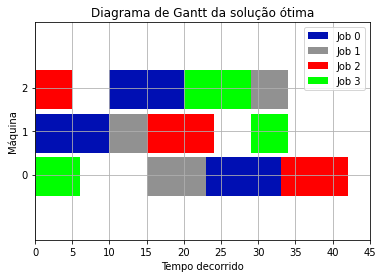

In [ ]:
import matplotlib.pyplot as plt 

fig, gnt = plt.subplots() 
gnt.grid(True) 
gnt.set_title('Diagrama de Gantt da solução ótima')

# Tamanho dos eixos
gnt.set_ylim(0, 50) 
gnt.set_xlim(0, 45) 

# Nomes dos eixos
gnt.set_xlabel('Tempo decorrido') 
gnt.set_ylabel('Máquina') 

# Espaçamento e Marcações do eixo y 
gnt.set_yticks([15, 25, 35]) 
gnt.set_yticklabels(['0', '1', '2']) 

# Dados ----------

# Job 0 na máquina 0
gnt.broken_barh([(23, 10)], (10, 9), facecolors = ('#000fb3'),label = 'Job 0') 
# Job 1 na máquina 0
gnt.broken_barh([(15, 8)], (10, 9), facecolors =('#919191'),label = 'Job 1') 
# Job 2 na máquina 0
gnt.broken_barh([(33, 9)], (10, 9), facecolors =('#ff0000'),label = 'Job 2') 
# Job 3 na máquina 0
gnt.broken_barh([(0, 6)], (10, 9), facecolors =('#00ff00'),label = 'Job 3') 

# Job 0 na máquina 1
gnt.broken_barh([(0, 10)], (20, 9), facecolors =('#000fb3')) 
# Job 1 na máquina 1
gnt.broken_barh([(10, 5)], (20, 9), facecolors =('#919191')) 
# Job 2 na máquina 1
gnt.broken_barh([(15, 9)], (20, 9), facecolors =('#ff0000')) 
# Job 3 na máquina 1
gnt.broken_barh([(29, 5)], (20, 9), facecolors =('#00ff00')) 

# Job 0 na máquina 2
gnt.broken_barh([(10, 20)], (30, 9), facecolors =('#000fb3')) 
# Job 1 na máquina 2
gnt.broken_barh([(29, 5)], (30, 9), facecolors =('#919191')) 
# Job 2 na máquina 2
gnt.broken_barh([(0, 5)], (30, 9), facecolors =('#ff0000')) 
# Job 3 na máquina 2
gnt.broken_barh([(20, 9)], (30, 9), facecolors =('#00ff00')) 
plt.legend()
